TensorFlow Version 1.3.1
TensorFlow version: 1.3.1
2.000000 * 3.000000 = 6.000000
-----  Sample model  -----
input layer: (?, 32, 32, 3)
flat layer: (?, 3072)
fc1 layer: (?, 390)
fc2 layer: (?, 200)
fc3 layer: (?, 10)
Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from lib/tf_models/proj/csci-599_proj-1528


INFO:tensorflow:Restoring parameters from lib/tf_models/proj/csci-599_proj-1528


Restored checkpoint from: lib/tf_models/proj/csci-599_proj-1528
-----  Start training  -----
train for epoch 0
global step: 1528
iteration (0): loss = 1.585, accuracy = 0.453
iteration (50): loss = 1.566, accuracy = 0.453
iteration (100): loss = 1.461, accuracy = 0.445
iteration (150): loss = 1.583, accuracy = 0.414
iteration (200): loss = 1.717, accuracy = 0.453
iteration (250): loss = 1.668, accuracy = 0.430
iteration (300): loss = 1.512, accuracy = 0.445
iteration (350): loss = 1.519, accuracy = 0.477
Model saved in lib/tf_models/proj/csci-599_proj-1910


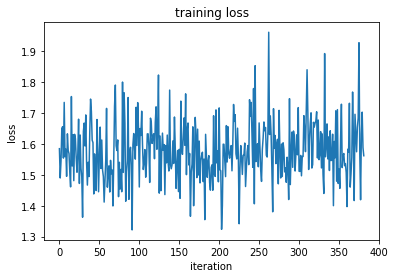

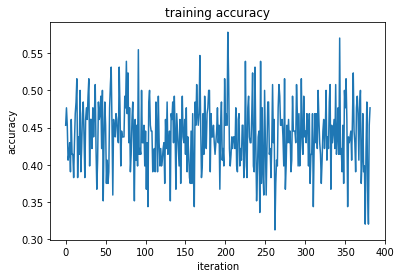

validation for epoch 0
-  epoch 0: validation accuracy = 0.423
train for epoch 1
global step: 1910
iteration (400): loss = 1.455, accuracy = 0.492
iteration (450): loss = 1.524, accuracy = 0.492
iteration (500): loss = 1.575, accuracy = 0.445
iteration (550): loss = 1.342, accuracy = 0.539
iteration (600): loss = 1.665, accuracy = 0.383
iteration (650): loss = 1.726, accuracy = 0.445
iteration (700): loss = 1.586, accuracy = 0.453
iteration (750): loss = 1.620, accuracy = 0.461
Model saved in lib/tf_models/proj/csci-599_proj-2292


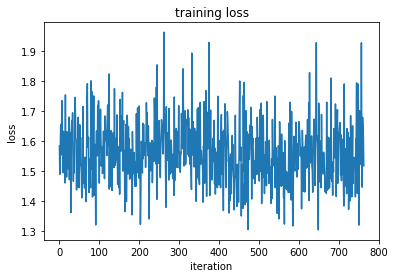

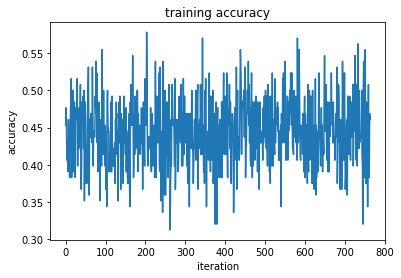

validation for epoch 1
-  epoch 1: validation accuracy = 0.443
***** test accuracy: 0.445


In [1]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))

# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

#############################################################################
#                             TODO:REMOVE THIS                              #
#############################################################################

# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']
    
def reshape_images(X):
    return X.reshape(-1, 3, 32, 32).transpose(0,2,3,1).astype("float")

def load_train_data():

    all_batches = []
    all_labels = []
    
    # load train and validation data
    num_batch = 5
    for i in range(num_batch):
        data_batch_i, labels_batch_i = unpickle('data/cifar-10-batches-py/data_batch_' + str(i+1))
        all_batches.append(reshape_images(data_batch_i))
        all_labels.append(np.array(labels_batch_i))
        
    data = np.concatenate(all_batches)
    labels = np.concatenate(all_labels)
        
    return data[:num_training], labels[:num_training], data[num_training:], labels[num_training:]

def load_test_data():
    
    # load test data
    data_batch_i, labels_batch_i = unpickle('data/cifar-10-batches-py/test_batch')
    data = reshape_images(data_batch_i)
    labels = np.array(labels_batch_i)
        
    return data, labels
    

# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

#############################################################################
#                             TODO:REMOVE THIS                              #
#############################################################################

# Define layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

def fully_connected(input, num_outputs, act_fn=None):
    return tf.contrib.layers.fully_connected(input, num_outputs,
                                             activation_fn=act_fn,
                                             weights_initializer=tf.random_normal_initializer(0.0, 0.02)
                                            )

class BaseModel(object):
    def __init__(self):
        self.num_epoch = 2
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('input layer: ' + str(self.X.get_shape()))
        
        self.flat = tf.reshape(self.X, [-1, np.prod(self.X.get_shape().as_list()[1:])])
              
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc1'):
            
            self.fc1 = fully_connected(self.flat, 390)
            self.relu1 = tf.nn.relu(self.fc1)
            
            print('fc1 layer: ' + str(self.relu1.get_shape()))

        with tf.variable_scope('fc2'):
            
            self.fc2 = fully_connected(self.relu1, 200)
            self.relu2 = tf.nn.relu(self.fc2)
            
            print('fc2 layer: ' + str(self.relu2.get_shape()))
            
        with tf.variable_scope('fc3'):
            
            self.fc3 = fully_connected(self.relu2, 10) # TODO: 200
            
            print('fc3 layer: ' + str(self.fc3.get_shape()))
        
        # Return the last layer
        return self.fc3

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        
        self.is_train = None
        self.keep_prob = None
        self.global_step = tf.Variable(0, trainable=False)
        self.starter_learning_rate = 5e-4
        
        # tf.train.exponential_decay(learning_rate, global_step, decay_steps, 
        # decay_rate, staircase=False, name=None)
        # staircase: Boolean. If True decay the learning rate at discrete intervals
        
        # decay every 500 steps with a base of 0.96
        self.learning_rate = tf.train.exponential_decay(self.starter_learning_rate,
                                                        self.global_step, 500, 0.96,
                                                        staircase=True)
        

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        
        # Passing global_step to minimize() will increment it at each step.
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = optimizer.minimize(self.loss_op, global_step=self.global_step)
        
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        self.loss_op = tf.reduce_mean(loss)     
        

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        
        # try loading checkpoint
        saver = tf.train.Saver()
        save_dir = "lib/tf_models/proj/"        
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, 'csci-599_proj')
        
        try:
            print("Trying to restore last checkpoint ...")

            # Use TensorFlow to find the latest checkpoint - if any.
            last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

            # Try and load the data in the checkpoint.
            saver.restore(sess, save_path=last_chk_path)

            # If we get to this point, the checkpoint was successfully loaded.
            print("Restored checkpoint from:", last_chk_path)
        except:
            # If the above failed for some reason, simply
            # initialize all the variables for the TensorFlow graph.
            print("Failed to restore checkpoint. Initializing variables instead.")
            sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            print('global step: %d' % self.global_step.eval())
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]
                
                feed_dict = {
                    self.X: X_,
                    self.Y: Y_
                }                
                
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1
            
            # save state
            model_path = saver.save(sess,
                       save_path=save_path,
                       global_step=self.global_step)
            print("Model saved in %s" % model_path)

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            # Graph 1. X: epoch, Y: training loss
            plt.plot(losses)
            plt.title('training loss')
            plt.xlabel('iteration')
            plt.ylabel('loss')
            plt.show()    

            # Graph 2. X: epoch, Y: training accuracy
            plt.plot(accuracies)
            plt.title('training accuracy')
            plt.xlabel('iteration')
            plt.ylabel('accuracy')
            plt.show()

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            
            feed_dict = {
                    self.X: X_,
                    self.Y: Y_
                }
            
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter
    
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session(config=tf.ConfigProto(
      allow_soft_placement=True)) as sess:
    with tf.device('/gpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)